# Frequency Domain Analysis

In [1]:
from scipy.fft import rfft, rfftfreq
from matplotlib import pyplot as plt
from math import sin,cos
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numpy.fft import fft,rfft
from scipy import fftpack
from Data_preparation_Library import *
from random import shuffle
from scipy import signal
from hampel import hampel
from scipy.signal import resample

In [2]:
def filter_data(data, f, butterworth_order = 4, btype = 'lowpass'):
    emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
    emg_data = data[emg_labels]
    
    f_sampling = 2000
    nyquist = f_sampling/2
    if isinstance(f, int):
        fc = f/nyquist
    else:
        fc = list(f)
        for i in range(len(f)):
            fc[i] = fc[i]/nyquist
            
    b,a = signal.butter(butterworth_order, fc, btype=btype)
    transpose = emg_data.T.copy()
    
    for i in range(len(transpose)):
        transpose[i] = (signal.lfilter(b, a, transpose[i]))
    
    filtered = pd.DataFrame(transpose.T)
    data[emg_labels] = filtered.values
    return data

In [3]:
def single_analyse(y,rms_win=200):
    fig, ax = plt.subplots(3,1,figsize=(16,12))
    ax[0].title.set_text('Raw EMG')
    ax[0].plot(y)
    
    ax[1].title.set_text('RMS EMG')
    ax[1].plot(rms(y,rms_win))
    
#     scaler = MinMaxScaler(feature_range=(-1,1))
#     mx = scaler.fit_transform(y.reshape(-1,1))
#     ax[2].title.set_text('MinMax EMG')
#     ax[2].plot(mx)
    
    ax[2].title.set_text('Freaquency Domain EMG')
    spec,freq,line = ax[2].magnitude_spectrum(y,Fs=2000)
    gg = np.matmul(spec.reshape(-1,1),np.transpose(freq.reshape(-1,1)))

In [4]:
def window_analyse(y,rms_win=200):
    window = len(y)
    fig, ax = plt.subplots(3,1,figsize=(16,12))
    ax[0].title.set_text('Raw EMG')
    ax[0].plot(y)
    
    ax[1].title.set_text('RMS EMG')
    ax[1].plot(rms_df(y,rms_win))
    
#     scaler = MinMaxScaler(feature_range=(-1,1))
#     mx = scaler.fit_transform(y)
#     ax[2].title.set_text('MinMax EMG')
#     ax[2].plot(mx)
    
    ax[2].title.set_text('Freaquency Domain EMG')
    for i in range(y.shape[1]):
        x = y[:,i]
        spec,freq,line = ax[2].magnitude_spectrum(x,2000)

In [5]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [6]:
def freaq_window(data,Fs=2000):
    spec_list = []
    for i in range(data.shape[1]):
        y = data[:,i]
        spec,freq,line = plt.magnitude_spectrum(y,Fs)
        spec_list.append(spec)
    X = np.array(spec_list[0])
    for x in spec_list[1:]:
        X = np.vstack((X,np.array(x)))
    return np.transpose(X)

<AxesSubplot:title={'center':'EMG Signal'}>

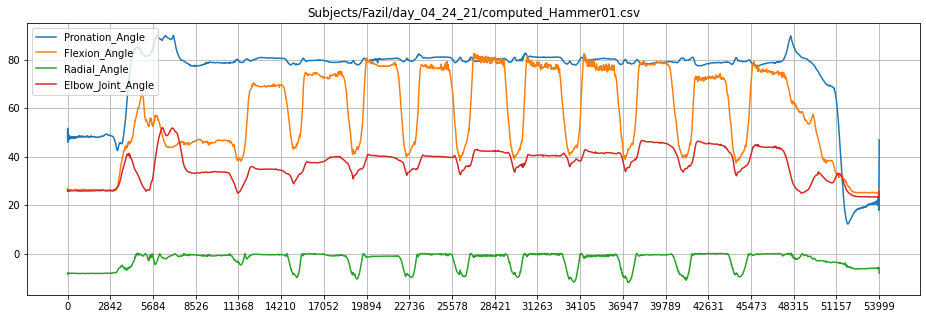

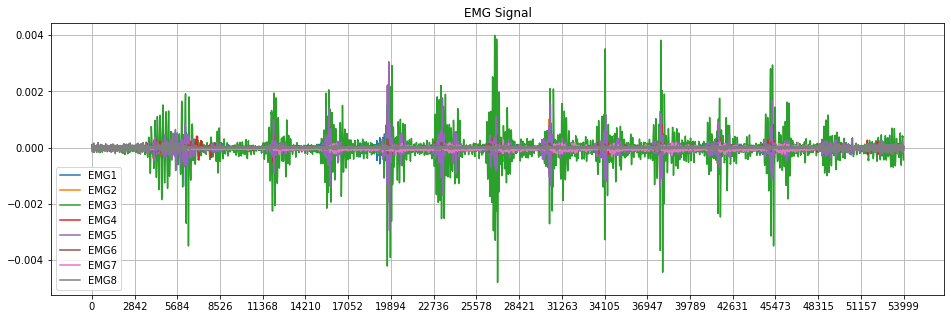

In [12]:
file = 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv'
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
main_df = pd.read_csv(file,index_col=0)
main_df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(main_df.index[0],main_df.index[-1],20))


sig = main_df[emg_labels]
b,a = signal.butter(1, 50,fs=2000)
lsig = pd.DataFrame(columns=emg_labels)
for labels in lsig.columns:
    lsig[labels] = signal.lfilter(b, a,sig[labels])
# sig = lsig
sig.plot(figsize=(16,5),title='EMG Signal',grid=True,xticks=np.linspace(main_df.index[0],main_df.index[-1],20))

## Audio Sampling

In [25]:
def resample_series(data,sr_origin,sr_new):
    """
    Upsamples Series Vector to required Freq(Hz)
    data - Series 1D Array
    sr_origin - Origin Sampling Rate
    sr_new - New Sampling Rate
    Return - Resampled Data to Given Sample Rate
    """
    data = np.array(data)
    ln = data.shape[0]
    new_ln = int(ln*(sr_new/sr_origin))
    resampled_array = resample(data,new_ln)    
    return np.array(resampled_array)

In [62]:
from scipy.io.wavfile import write
gain = 1000
audio_sr = 44100
audio_sig = []
for label in emg_labels:
    audio_sig.append(resample_series(sig[label],2000,audio_sr))
    
audio_sig = np.array(audio_sig)*gain
audio_sig = pd.DataFrame(audio_sig.reshape(audio_sig.shape[1],8),columns=emg_labels)
write('noise.wav', audio_sr, audio_sig.values)